pip install git+https://git.fmrib.ox.ac.uk/fsl/fslnets.git

Need to be run to use this

# Have to rerun everything when i have more subjects - as the group ICA needs to be re-estimated and then all that comes afterwards (which is essentially everything)

For future self:
* don't use the _Z files in .dr folders. Less recommended in my understanding. 

* Do subgroups analysis


* to install packages and maybe run some stuff in the terminal I might need sometimes to run: conda activate myenv


# Import stuff + params

In [1]:
from fsl import nets
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# need to set up to run fsl.
os.environ['FSLDIR'] = '/export/home/ranigera/fsl'
os.environ['PATH'] += ':/export/home/ranigera/fsl/bin'

group_ICA_path = '/export/home/ranigera/IDCH-rsfMRI/data/group_ICA'
rs_data_path = '/export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data'
rs_data_path_IDCH_sub_Nums = '/export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums'

whole_network_path = '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks'

input_files_file_name = 'input_files.txt'
input_files_txt_path = os.path.join(group_ICA_path, input_files_file_name)
# n_ICs = 50 # number of independent components
TR = 0.70 # repetition time in seconds

# (original) file_format:
any_session_file_format = '_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz'
stage2_ic_file_prefix = 'dr_stage2_ic' # move to params

# R01 to IDCH mapping:
mapping_R01_to_IDCH = {'222': '101', '183': '102', '216': '103', '192': '104', '251': '105', '206': '106', '180': '107', '184': '108', '169': '109', '207': '110',
                       '159': '111', '115': '112', '114': '113', '232': '114', '173': '115', '171': '117', '215': '118', '265': '119', '177': '120', '269': '121',
                       '261': '122'}

main_behav_file = '/export/home/ranigera/IDCH-rsfMRI/data/behav_data/merged_behav_data.csv'

In [2]:
n_ICs=20 # number of independent components
# run slices_summary:
# check if exists:
if not os.path.exists(f'{group_ICA_path}/groupICA{n_ICs}.sum'):
    os.system(f'slices_summary {group_ICA_path}/groupICA{n_ICs}/melodic_IC 4 $FSLDIR/data/standard/MNI152_T1_2mm {group_ICA_path}/groupICA{n_ICs}.sum -1')


## concatenate the time series per subject

In [3]:
concat_ts_path = os.path.join(whole_network_path, 'concatenated_IC_ts')
if not os.path.exists(concat_ts_path):
    os.makedirs(concat_ts_path)

dual_regressed_path = os.path.join(f'{group_ICA_path}/groupICA{n_ICs}.dr')
file_list = sorted(glob.glob(f'{dual_regressed_path}/*stage1*.txt'))

maching_IDCH_sub_list = sorted(mapping_R01_to_IDCH.values())

for i in range(0, len(file_list), 2):
    sub_data1 = np.loadtxt(file_list[i])
    sub_data2 = np.loadtxt(file_list[i+1])
    # concatenate the two subjects' data
    sub_data_concat = np.concatenate((sub_data1, sub_data2), axis=0)
    # save the concatenated data
    np.savetxt(f'{concat_ts_path}/dr_stage1_{maching_IDCH_sub_list[i//2]}.txt', sub_data_concat, fmt='%.10g')


# Explore all data (across all subjects)

In [134]:
ts = nets.load(f'{concat_ts_path}', 0.70, varnorm=0, nruns=2, thumbnaildir=f'{group_ICA_path}/groupICA{n_ICs}.sum')

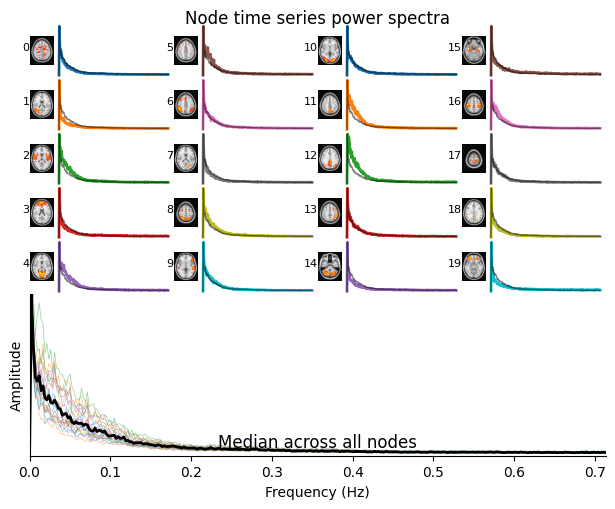

In [138]:
nets.plot_spectra(ts);

In [ ]:
# If I have bad components that I want to clean up.
#nets.clean(ts, goodnodes, True)


In [41]:
# # plot time series for each component (each subject is a line):
# for i in range(ts.ts[0].shape[2]):
#     for j in range(len(ts.ts)):
#         plt.plot(ts.ts[j][:,:,i][0])
#     plt.title(f'IC {i}')
#     plt.show()


In [153]:
Fnetmats = nets.netmats(ts, 'corr',   True)
Pnetmats = nets.netmats(ts, 'ridgep', True, 0.1) # partial correlations with regularization

In [140]:
Znet_F, Mnet_F = nets.groupmean(ts, Fnetmats, False)
# NOTE: Seeing this 'invalid value encountered in true_divide' should be fine according to their tutorial (fsl's)


invalid value encountered in divide


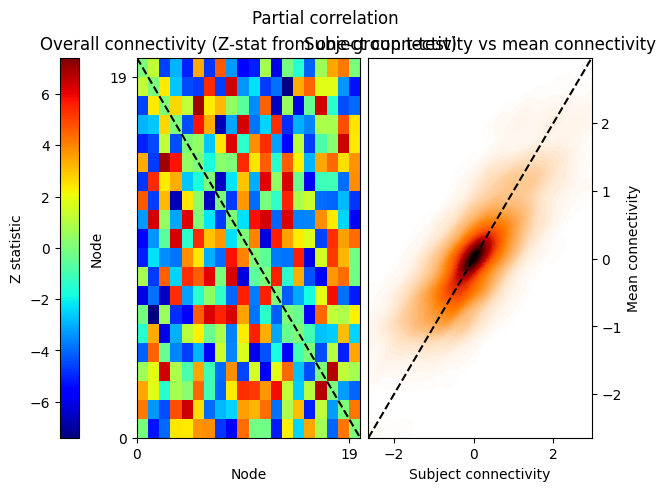

In [141]:
Znet_P, Mnet_P = nets.groupmean(ts, Pnetmats, True, 'Partial correlation') # "saves out both the simple average of netmats across all subjects (Mnet) and the results of a simple one-group t-test (against zero) across subjects as Z values (Znet)."
# NOTE: Seeing this 'invalid value encountered in true_divide' should be fine according to their tutorial (fsl's)
# NOTE: I think the left is the result of one sample t-test at each edge. not the average partial correlation (which is in Mnet_P)

([0, 7, 15, 1, 14, 18, 19, 3, 12, 9, 17, 16, 5, 2, 13, 6, 11, 8, 4, 10],
 array([[8.00000000e+00, 4.00000000e+00, 0.00000000e+00, 2.00000000e+00],
        [1.10000000e+01, 2.00000000e+01, 4.94811436e-03, 3.00000000e+00],
        [1.20000000e+01, 9.00000000e+00, 2.42479181e-02, 2.00000000e+00],
        [5.00000000e+00, 2.00000000e+00, 2.77946673e-02, 2.00000000e+00],
        [1.60000000e+01, 2.30000000e+01, 3.59361217e-02, 3.00000000e+00],
        [2.20000000e+01, 1.70000000e+01, 6.13888864e-02, 3.00000000e+00],
        [1.30000000e+01, 6.00000000e+00, 6.66476836e-02, 2.00000000e+00],
        [2.10000000e+01, 1.00000000e+01, 8.27556912e-02, 4.00000000e+00],
        [0.00000000e+00, 7.00000000e+00, 9.72927069e-02, 2.00000000e+00],
        [2.40000000e+01, 2.60000000e+01, 1.87782069e-01, 5.00000000e+00],
        [3.00000000e+00, 2.50000000e+01, 2.71210963e-01, 4.00000000e+00],
        [1.50000000e+01, 1.00000000e+00, 2.74433387e-01, 2.00000000e+00],
        [1.40000000e+01, 1.80000000e+01

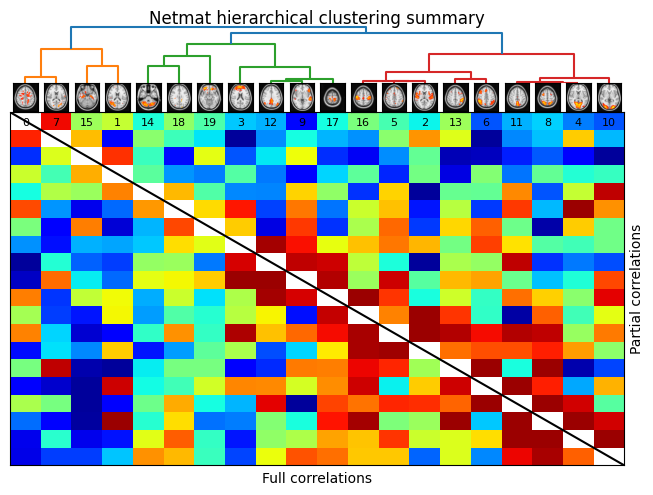

In [156]:
nets.plot_hierarchy(ts, Znet_F, Znet_P, 'Full correlations', 'Partial correlations')
# NOTE: full correlation drives the clustering, partial correlation just shown for comparison.

## code and instructions to run nets.web

In [60]:
# nets.web(ts, (Znet_F, Znet_P), ('Full correlation', 'Partial correlation'))
# this would actually work only by running it in the terminal in fslpython
# after the running the previous stuff I ran here:

# so start by entering fslpython in the terminal and then copy paste the following:
from fsl import nets
import os
n_ICs=20 # number of independent components
group_ICA_path = '/export/home/ranigera/IDCH-rsfMRI/data/group_ICA'

if not os.path.exists(f'{group_ICA_path}/groupICA{n_ICs}.sum'):
    os.system(f'slices_summary {group_ICA_path}/groupICA{n_ICs}/melodic_IC 4 $FSLDIR/data/standard/MNI152_T1_2mm {group_ICA_path}/groupICA{n_ICs}.sum -1')

ts = nets.load(f'{group_ICA_path}/groupICA{n_ICs}.dr', 0.70, varnorm=0, thumbnaildir=f'{group_ICA_path}/groupICA{n_ICs}.sum')
Fnetmats = nets.netmats(ts, 'corr',   True)
Pnetmats = nets.netmats(ts, 'ridgep', True, 0.1) # partial correlations with regularization
Znet_F, Mnet_F = nets.groupmean(ts, Fnetmats, False)
Znet_P, Mnet_P = nets.groupmean(ts, Pnetmats, True, 'Partial correlation') # "saves out both the simple average of netmats across all subjects (Mnet) and the results of a simple one-group t-test (against zero) across subjects as Z values (Znet)."
nets.web(ts, (Znet_F, Znet_P), ('Full correlation', 'Partial correlation'))


# Analyze corr with behavior 

## Get behavior data

In [4]:
# Initial general stuff:
univariate_behav_corr_path = os.path.join(whole_network_path, f'univariateICA{n_ICs}.behavior_corr')
if not os.path.exists(univariate_behav_corr_path):
    os.makedirs(univariate_behav_corr_path)

univariate_behav_corr_input_data_folder = os.path.join(univariate_behav_corr_path, 'input_data')
if not os.path.exists(univariate_behav_corr_input_data_folder):
    os.makedirs(univariate_behav_corr_input_data_folder)

# load the behavior data:
main_behav_data = pd.read_csv(main_behav_file)
# change subID to int:
main_behav_data['subID'] = main_behav_data['subID'].astype(int)
main_behav_data

,subID,sequenceCompleted_test,sequenceCompleted_reacquisition,sequenceCompleted_combined,at_least_one_response_test,at_least_one_response_reacquisition,at_least_one_response_combined,devaluation,stillVal_minus_deval,preVal_relativeDiff_deval,meanVal_minus_deval,meanVal_relativeDiff_deval,meanVal_relativeDiff_deval_SQRT,std_diary,normed_std_diary,SRM_score,mood,Anxiety,Stress,routine_mean
0,101,1,11,12,1,11,12,0,34,1.000000,34.5,1.000000,1.000000,1281.631619,0.530220,2.200000,71.985294,34.367647,26.191176,3.593137
1,102,0,0,0,0,0,0,0,5,1.000000,4.0,1.000000,1.000000,966.548720,0.433184,4.125000,68.357143,22.000000,21.828571,3.638095
2,103,0,0,0,0,0,0,6,1,0.076923,-1.0,-0.090909,-0.045549,761.555304,0.372977,6.000000,63.100000,20.471429,18.957143,3.823810
3,104,0,0,0,0,0,0,3,12,0.666667,6.5,0.520000,0.280449,1200.262012,0.519515,3.058824,68.457143,14.714286,14.814286,4.095238
4,105,3,0,3,4,0,4,0,9,1.000000,8.0,1.000000,1.000000,1444.988375,0.595996,1.882353,62.536232,33.927536,42.318841,4.376812
5,106,1,0,1,2,0,2,4,26,0.764706,11.0,0.578947,0.318915,NaN,NaN,NaN,90.724138,3.896552,9.327586,5.902299
6,107,0,0,0,0,0,0,0,10,1.000000,6.5,1.000000,1.000000,1376.074428,0.555342,1.954545,66.402985,42.507463,37.104478,4.457711
7,108,0,0,0,0,0,0,0,3,1.000000,2.5,1.000000,1.000000,1065.073426,0.452931,1.571429,70.609375,25.718750,15.906250,5.072917
8,109,0,0,0,0,0,0,2,25,0.862069,15.5,0.794872,0.494699,971.316793,0.462965,3.000000,86.630769,3.384615,5.400000,5.907692
9,110,0,0,0,1,0,1,7,7,0.333333,2.0,0.125000,0.062746,1014.818277,0.480114,4.600000,66.428571,12.442857,28.271429,5.219048


## Create design matrix and con file

In [65]:
behav_var = 'at_least_one_response_test'

# get the data with subID and the behavior variable (and remove NaNs):
behav_data = main_behav_data[['subID', behav_var]].dropna().reset_index(drop=True)
num_data_points = len(behav_data['subID'])
demeaned_behav_data = behav_data[behav_var] - behav_data[behav_var].mean()

# Prepare the .mat file content
# --------------------------------------------------------------
header = f"""/NumWaves\t1
/NumPoints\t{num_data_points}

/Matrix
"""
# Format the matrix content
matrix_content = "\n".join([f"{value}\t" for value in demeaned_behav_data])
# Combine header and matrix content
design_matrix_content = header + matrix_content
print(design_matrix_content)
# Write the design matrix to a file
output_file = f'design_behav_corr_{behav_var}.mat'
output_file = os.path.join(univariate_behav_corr_input_data_folder, output_file)
with open(output_file, 'w') as file:
    file.write(design_matrix_content)
print(f"Design matrix file '{output_file}' created successfully!")


# Prepare the .con file content
# --------------------------------------------------------------
# Parameters for the contrast file
num_waves = 1  # As per your new design, only one EV
num_contrasts = 1  # Two contrasts: positive and negative

# Matrix for contrasts
# Positive correlation: 1 for the EV
# Negative correlation: -1 for the EV
contrast_matrix = [
    [1.0],  # Positive correlation
]

# Create the .con file content
header = f"""/NumWaves\t{num_waves}
/NumContrasts\t{num_contrasts}

/Matrix
"""
# Format the matrix content
matrix_content = "\n".join(["\t".join([f"{value}" for value in row]) for row in contrast_matrix])
# Combine header and matrix content
contrast_matrix_content = header + matrix_content
print(contrast_matrix_content)
# Write the contrast matrix to a file
output_file = f'design_behav_corr_{behav_var}_pos_corr.con'
output_file = os.path.join(univariate_behav_corr_input_data_folder, output_file)
with open(output_file, 'w') as file:
    file.write(contrast_matrix_content)
print(f"Contrast matrix file '{output_file}' created successfully!")

# Create the .con file content for negative correlation [HAS TO BE DONE SEPERATELY BECAUSE OF HOW THE nets.glm HANDLE THE CONTRASTS WITH ONE EV]
contrast_matrix = [
    [-1.0]  # Negative correlation
]
# Format the matrix content
matrix_content = "\n".join(["\t".join([f"{value}" for value in row]) for row in contrast_matrix])
# Combine header and matrix content
contrast_matrix_content = header + matrix_content
print(contrast_matrix_content)
# Write the contrast matrix to a file
output_file = f'design_behav_corr_{behav_var}_neg_corr.con'
output_file = os.path.join(univariate_behav_corr_input_data_folder, output_file)
with open(output_file, 'w') as file:
    file.write(contrast_matrix_content)
print(f"Contrast matrix file '{output_file}' created successfully!")


/NumWaves	1
/NumPoints	21

/Matrix
-0.8095238095238095	
-1.8095238095238095	
-1.8095238095238095	
-1.8095238095238095	
2.1904761904761907	
0.19047619047619047	
-1.8095238095238095	
-1.8095238095238095	
-1.8095238095238095	
-0.8095238095238095	
-1.8095238095238095	
-1.8095238095238095	
-1.8095238095238095	
6.190476190476191	
-0.8095238095238095	
-1.8095238095238095	
0.19047619047619047	
9.19047619047619	
6.190476190476191	
-1.8095238095238095	
-1.8095238095238095	
Design matrix file '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/univariateICA20.behavior_corr/input_data/design_behav_corr_at_least_one_response_test.mat' created successfully!
/NumWaves	1
/NumContrasts	1

/Matrix
1.0
Contrast matrix file '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/univariateICA20.behavior_corr/input_data/design_behav_corr_at_least_one_response_test_pos_corr.con' created successfully!
/NumWaves	1
/NumContrasts	1

/Matrix
-1.0
Contrast matrix file '/export/home/ranigera/IDCH-rsfMRI/data/who

## Load as the relevant data as a ts object

In [66]:
relevant_file = [f'{concat_ts_path}/dr_stage1_{subj}.txt' for subj in behav_data.subID]
ts = nets.load(relevant_file, 0.70, varnorm=0, nruns=2, thumbnaildir=f'{group_ICA_path}/groupICA{n_ICs}.sum')
Fnetmats = nets.netmats(ts, 'corr',   True)
Pnetmats = nets.netmats(ts, 'ridgep', True, 0.1) # partial correlations with regularization

Positive correlation for at_least_one_response_test [with partial correlation]:
53304

---------------------------
Contrast 1 [1] - no results
---------------------------

Negative correlation for at_least_one_response_test [with partial correlation]:
53379

----------------------------
Contrast 1 [-1] - no results
----------------------------

Positive correlation for at_least_one_response_test [with full correlation]:
53452

--------------
Contrast 1 [1]
--------------

Node i | Node j | T statistic | P value
------ | ------ | ----------- | -------
4      | 7      | 4.1846533   | 0.9678 
Negative correlation for at_least_one_response_test [with full correlation]:
53524

----------------------------
Contrast 1 [-1] - no results
----------------------------



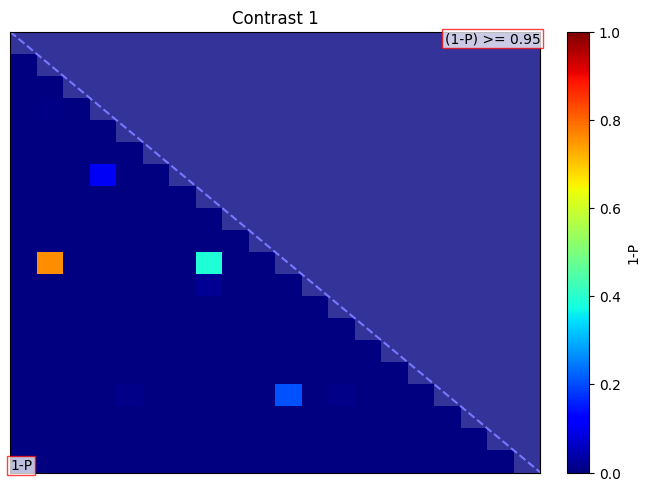

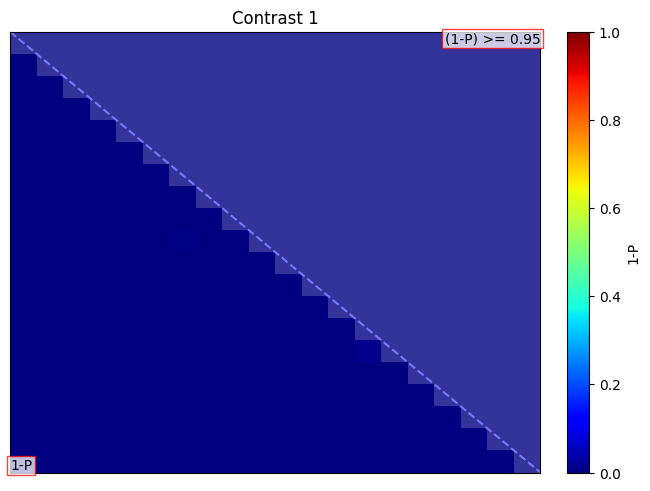

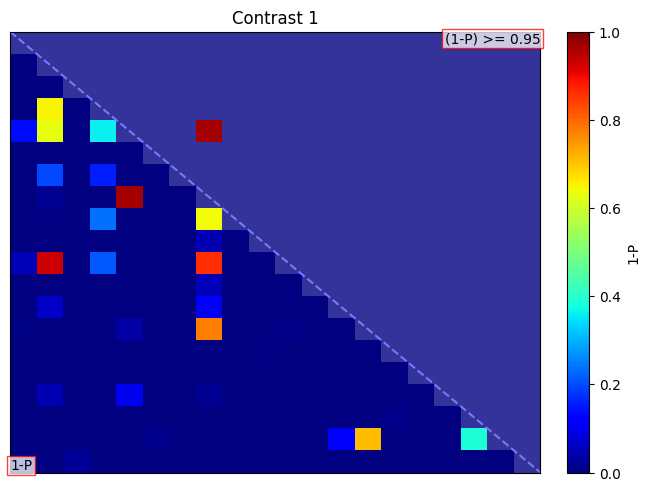

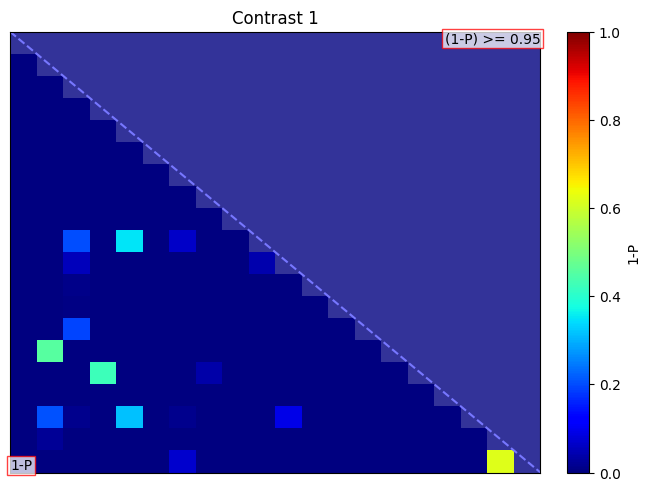

In [67]:
print(f'Positive correlation for {behav_var} [with partial correlation]:')
p_corr,p_uncorr = nets.glm(ts, Pnetmats, os.path.join(univariate_behav_corr_input_data_folder, f'design_behav_corr_{behav_var}.mat'), os.path.join(univariate_behav_corr_input_data_folder, f'design_behav_corr_{behav_var}_pos_corr.con'))
print(f'Negative correlation for {behav_var} [with partial correlation]:')
p_corr,p_uncorr = nets.glm(ts, Pnetmats, os.path.join(univariate_behav_corr_input_data_folder, f'design_behav_corr_{behav_var}.mat'), os.path.join(univariate_behav_corr_input_data_folder, f'design_behav_corr_{behav_var}_neg_corr.con'))
print(f'Positive correlation for {behav_var} [with full correlation]:')
p_corr,p_uncorr = nets.glm(ts, Fnetmats, os.path.join(univariate_behav_corr_input_data_folder, f'design_behav_corr_{behav_var}.mat'), os.path.join(univariate_behav_corr_input_data_folder, f'design_behav_corr_{behav_var}_pos_corr.con'))
print(f'Negative correlation for {behav_var} [with full correlation]:')
p_corr,p_uncorr = nets.glm(ts, Fnetmats, os.path.join(univariate_behav_corr_input_data_folder, f'design_behav_corr_{behav_var}.mat'), os.path.join(univariate_behav_corr_input_data_folder, f'design_behav_corr_{behav_var}_neg_corr.con'))

59923

--------------
Contrast 1 [1]
--------------

Node i | Node j | T statistic | P value
------ | ------ | ----------- | -------
4      | 7      | 4.1846533   | 0.9678 


invalid value encountered in divide


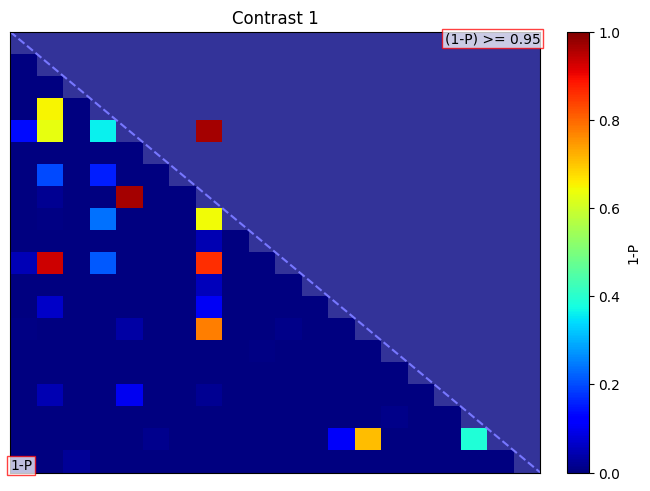

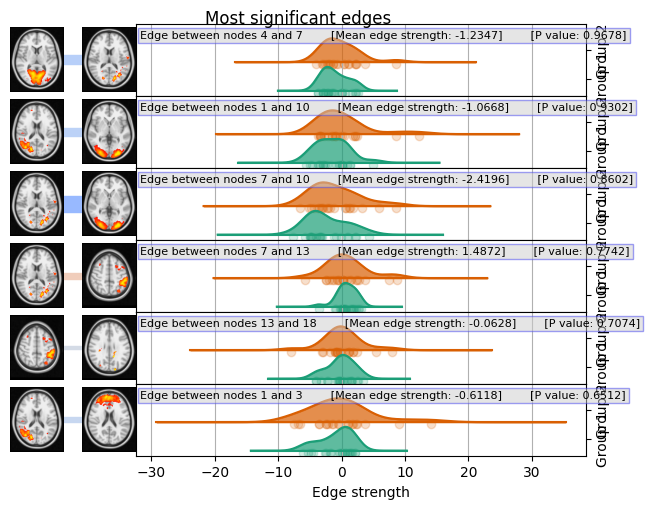

In [77]:
p_corr,p_uncorr = nets.glm(ts, Fnetmats, os.path.join(univariate_behav_corr_input_data_folder, f'design_behav_corr_{behav_var}.mat'), os.path.join(univariate_behav_corr_input_data_folder, f'design_behav_corr_{behav_var}_pos_corr.con'))
Znet_F, Mnet_F = nets.groupmean(ts, Fnetmats, False)
nets.boxplots(ts, Fnetmats, Znet_F, p_corr[0])
plt.show()
# if I have groups I should use this I think:
# nets.boxplots(ts, Fnetmats, Znet_F, p_corr[0], groups=(6, 6))

# ABOUT:
# "Each pair of thumbnails corresponds to one position in the NxN network matrix and the node numbers are listed in the text captions.
# The coloured bar joining each pair of nodes tells you what the overall group-average connection strength is: thicker means a stronger connection; red means it's positive, and blue means that the connection is "negative" (meaning that the two nodes tend to anti-correlate on average).
# The "P value" numbers tell you the 1-p-values - so the higher these are, the more significantly different this edge strength is between the two groups. Anything less than 0.95 is not significant, after correcting for multiple comparisons."

In [68]:
nets.boxplots?

Signature:
nets.boxplots(
    ts,
    netmats,
    znetmat,
    pnetmat,
    groups=None,
    nedges=6,
    edges=None,
)
Docstring:
Show per-group distributions of connectivity strength for the <nedges>
most significant edges, or for the specified <edges>.

ts:      TimeSeries object
netmats: (subjects, edges) array containing per-subject netmats.
znetmat: (nodes, nodes) array containing mean netmat values (assumed to be
         Z-normalised)
pnetmat  (nodes, nodes) array containing P-values for each edge
groups:  Number of subjects in each group
nedges:  show the N strongest edges.
edges:   Show these specific edges - sequence of (nodei, nodej) pairs.
File:      ~/miniconda3/envs/myenv/lib/python3.12/site-packages/fsl/nets/boxplots.py
Type:      function

In [163]:
Pnetmats.shape

(42, 400)

In [85]:
nets.glm?

Signature:
nets.glm(
    ts,
    netmats,
    design,
    contrasts,
    nperms=5000,
    plot=True,
    title=None,
)
Docstring:
Perform a cross-subject GLM on a set of netmats, giving uncorrected and
corrected (1-p) values.

Randomise (permutation testing) is used to get corrected 1-p-values (i.e.,
correcting for multiple comparisons across the NxN netmat elements).

ts:        TimeSeries object

netmats:   (subjects, edges) array containing per-subject netmats.

design:    Path to a FSL design matrix file denoting subject groups. The
           rows must be in the same order as the subject order in netmats.

contrasts: Path to a FSL contrast file specifying the contrasts to test.

nperms:    Number of non-parametric permutations to apply

plot:      Display a (nodes, nodes) matrix of P-values (one per contrast)
           highlighting edges that were found to have significantly
           different strength.

           1-corrected-p values are shown below the diagonal. The same
   

In [ ]:
p_corr,p_uncorr = nets.glm(ts, Pnetmats, 'design/unpaired_ttest_1con.mat', 'design/unpaired_ttest_1con.con') # "To perform the comparison run the following command (which calls randomise from within Python, with 5000 permutations for each contrast)"


In [ ]:
output_file = f'design_behav_corr_{behav_var}.con'
output_file = os.path.join(univariate_behav_corr_input_data_folder, output_file)


In [5]:
?nets.web

Signature:
nets.web(
    ts,
    netmats,
    labels,
    savedir=None,
    openpage=True,
    nclusts=6,
    thumbthres=0.25,
)
Docstring:
Open an interactive netmat viewer in a web browser.

ts:         TimeSeries object

netmats:    List of (nodes, nodes) netmat arrays

labels:     List of labels for each netmat

savedir:    Optional path to save HTML/Javascript files for later viewing.
            If not provided, files are saved to a temporary location.

openpage:   Set to False if you don't want the web page to be opened
            immediately.

nclusts:    Colour and separate nodes into this many clusters.

thumbthres: Threshold in the range [0, 1] - pixels in thumbnail images with
            an intensity lower than this will be made transparent.
File:      ~/miniconda3/envs/myenv/lib/python3.12/site-packages/fsl/nets/web.py
Type:      function

# Preperation

## Copy data to be with IDCH sub numbers (and extract the brain)

In [9]:
# get all directories in the rs_data_path:
r01_sub_dirs = [f for f in os.listdir(rs_data_path) if os.path.isdir(os.path.join(rs_data_path, f))]
# iterate over all subjects:
for dir in r01_sub_dirs:
    sub_dir = os.path.join(rs_data_path, dir, 'func') 
    sub_R01_id = dir.split('Hab0')[1][:3] # get sub R01 id
    sub_IDCH_id = mapping_R01_to_IDCH[sub_R01_id] # get sub IDCH id

    # get subject's resting state:
    rs_files = [f for f in os.listdir(sub_dir) if any_session_file_format in f]
    for f in rs_files:
        # get the session number:
        session = f.split('rest_run-')[1][0]
        new_file_name = f'sub-{sub_IDCH_id}_ses-{session}_rest_MNI152-smoothAROMAnonaggr_bold_brain.nii.gz'
        # copy the file if not exists:
        if not os.path.exists(os.path.join(rs_data_path_IDCH_sub_Nums, new_file_name)):
            print(f'> Copying {f} to {new_file_name}')
            # os.system(f'cp {os.path.join(sub_dir, f)} {os.path.join(rs_data_path_IDCH_sub_Nums, new_file_name)}')
            os.system(f'fslmaths {os.path.join(sub_dir, f)} -mas $FSLDIR/data/standard/MNI152_T1_2mm_brain_mask.nii.gz {os.path.join(rs_data_path_IDCH_sub_Nums, new_file_name)}')
        # write the file name to the input_files.txt file:


## Create input_files.txt file needed for the group ICA

In [10]:
# create group_ICA_path if it does not exist
if not os.path.exists(group_ICA_path):
    os.makedirs(group_ICA_path)

# list all files in all subdirectories of rs_data_path_IDCH_sub_Nums
rs_data_files = []
for root, dirs, files in os.walk(rs_data_path_IDCH_sub_Nums):
    for file in files:
        if file.endswith('.nii.gz'):
            rs_data_files.append(os.path.join(root, file))
print('Number of files:', len(rs_data_files))
rs_data_files.sort()

with open(input_files_txt_path, 'w') as f:
    for file in rs_data_files:
        f.write(file + '\n')
rs_data_files

Number of files: 42


['/export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-101_ses-1_rest_MNI152-smoothAROMAnonaggr_bold_brain.nii.gz',
 '/export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-101_ses-2_rest_MNI152-smoothAROMAnonaggr_bold_brain.nii.gz',
 '/export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-102_ses-1_rest_MNI152-smoothAROMAnonaggr_bold_brain.nii.gz',
 '/export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-102_ses-2_rest_MNI152-smoothAROMAnonaggr_bold_brain.nii.gz',
 '/export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-103_ses-1_rest_MNI152-smoothAROMAnonaggr_bold_brain.nii.gz',
 '/export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-103_ses-2_rest_MNI152-smoothAROMAnonaggr_bold_brain.nii.gz',
 '/export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-104_ses-1_rest_MNI152-smoothAROMAnonaggr_bold_brain.nii.gz',
 '/export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/s

# Run group ICA (creates commad)

In [11]:
n_ICs=50 # number of independent components
print(f'melodic -i {input_files_txt_path} -o {group_ICA_path}/groupICA{n_ICs} --tr=0.70 --nobet -a concat --bgimage=$FSLDIR/data/standard/MNI152_T1_2mm_brain.nii.gz -m $FSLDIR/data/standard/MNI152_T1_2mm_brain_mask.nii.gz --report --Oall -d {n_ICs}')
n_ICs=40
print(f'melodic -i {input_files_txt_path} -o {group_ICA_path}/groupICA{n_ICs} --tr=0.70 --nobet -a concat --bgimage=$FSLDIR/data/standard/MNI152_T1_2mm_brain.nii.gz -m $FSLDIR/data/standard/MNI152_T1_2mm_brain_mask.nii.gz --report --Oall -d {n_ICs}')
n_ICs=30
print(f'melodic -i {input_files_txt_path} -o {group_ICA_path}/groupICA{n_ICs} --tr=0.70 --nobet -a concat --bgimage=$FSLDIR/data/standard/MNI152_T1_2mm_brain.nii.gz -m $FSLDIR/data/standard/MNI152_T1_2mm_brain_mask.nii.gz --report --Oall -d {n_ICs}')
n_ICs=20
print(f'melodic -i {input_files_txt_path} -o {group_ICA_path}/groupICA{n_ICs} --tr=0.70 --nobet -a concat --bgimage=$FSLDIR/data/standard/MNI152_T1_2mm_brain.nii.gz -m $FSLDIR/data/standard/MNI152_T1_2mm_brain_mask.nii.gz --report --Oall -d {n_ICs}')
# Determine # of components automatically (tend to create a LOT of components):
# print(f'melodic -i {input_files_txt_path} -o {group_ICA_path}/groupICA{"auto_n_ICs"} --tr=0.70 --nobet -a concat --bgimage=$FSLDIR/data/standard/MNI152_T1_2mm_brain.nii.gz -m $FSLDIR/data/standard/MNI152_T1_2mm_brain_mask.nii.gz --report --Oall')


melodic -i /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/input_files.txt -o /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA50 --tr=0.70 --nobet -a concat --bgimage=$FSLDIR/data/standard/MNI152_T1_2mm_brain.nii.gz -m $FSLDIR/data/standard/MNI152_T1_2mm_brain_mask.nii.gz --report --Oall -d 50
melodic -i /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/input_files.txt -o /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA40 --tr=0.70 --nobet -a concat --bgimage=$FSLDIR/data/standard/MNI152_T1_2mm_brain.nii.gz -m $FSLDIR/data/standard/MNI152_T1_2mm_brain_mask.nii.gz --report --Oall -d 40
melodic -i /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/input_files.txt -o /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA30 --tr=0.70 --nobet -a concat --bgimage=$FSLDIR/data/standard/MNI152_T1_2mm_brain.nii.gz -m $FSLDIR/data/standard/MNI152_T1_2mm_brain_mask.nii.gz --report --Oall -d 30
melodic -i /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/input_files.txt -o /expor

# Run dual regression (creates command)

* This is dual regression without the 3rd step of group analysis. This is done separately later)

In [5]:
n_ICs=20 # number of independent components
print(f'dual_regression {group_ICA_path}/groupICA{n_ICs}/melodic_IC 1 \
      -1 0 \
      {group_ICA_path}/groupICA{n_ICs}.dr {" ".join(item for item in rs_data_files)}')

dual_regression /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA20/melodic_IC 1       -1 0       /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA20.dr /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-101_ses-1_rest_MNI152-smoothAROMAnonaggr_bold_brain.nii.gz /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-101_ses-2_rest_MNI152-smoothAROMAnonaggr_bold_brain.nii.gz /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-102_ses-1_rest_MNI152-smoothAROMAnonaggr_bold_brain.nii.gz /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-102_ses-2_rest_MNI152-smoothAROMAnonaggr_bold_brain.nii.gz /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-103_ses-1_rest_MNI152-smoothAROMAnonaggr_bold_brain.nii.gz /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-103_ses-2_rest_MNI152-smoothAROMAnonaggr_bold_brain.nii.gz /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH

## Averaging each subect's data (over the two sessions) for each IC [and renaming back to IDCH sub-IDs instead of the one attached automaticaaly starting at 0000]

In [6]:
n_ICs=20

maching_IDCH_sub_list = sorted(mapping_R01_to_IDCH.values())
sub_avg_folder = os.path.join(group_ICA_path, f'groupICA{n_ICs}.sub_avg')
if not os.path.exists(sub_avg_folder):
    os.makedirs(sub_avg_folder)

for IC in range(n_ICs):
    print(f'Processing IC {IC}')
    IC_str = str(IC).zfill(4) # get the IC into a string that has 4 digits

    # Check that files were not already created:
    sub_IC_avg_files = [f for f in os.listdir(sub_avg_folder) if f.startswith(f'IC{IC_str}_sessions-avg_ordered-sub-')]
    N_sub_by_ses_files = [f for f in os.listdir(rs_data_path_IDCH_sub_Nums)]    
    if len(sub_IC_avg_files) == len(N_sub_by_ses_files)/2:
        print(f'All IC{IC_str}_sessions-avg_ordered-sub-*.nii.gz already exists')
        continue
    
    # split the IC data into sub-ICs:
    file_name = f'{stage2_ic_file_prefix}{IC_str}.nii.gz'
    file_path = os.path.join(group_ICA_path, f'groupICA{n_ICs}.dr', file_name)
    print('Splitting:', file_path)
    os.system(f'fslsplit {file_path} {sub_avg_folder}/IC{IC_str}_ -t') # split the IC into sub-ICs:

    # get the sub_IC_files:
    sub_IC_files = [f for f in os.listdir(sub_avg_folder) if f.startswith(f'IC{IC_str}_')]
    sub_IC_files = [f for f in sub_IC_files if 'avg' not in f]
    sub_IC_files.sort()

    # iterate over the sub_IC_files in pairs and concatenate them:
    for i in range(0, len(sub_IC_files), 2):
        sub_file1 = os.path.join(sub_avg_folder, sub_IC_files[i])
        sub_file2 = os.path.join(sub_avg_folder, sub_IC_files[i+1])
        # check if the concatenated file exists:
        if not os.path.exists(f'{sub_avg_folder}/IC{IC_str}_sessions-avg_ordered-sub-{maching_IDCH_sub_list[i//2]}.nii.gz'):
            os.system(f'fslmaths {sub_file1} -add {sub_file2} -div 2 {sub_avg_folder}/IC{IC_str}_sessions-avg_ordered-sub-{maching_IDCH_sub_list[i//2]}.nii.gz') # this calculate the average in the right way. I TESTED IT!
            print('processing:', sub_file1, sub_file2)
            print(f'Created {sub_avg_folder}/IC{IC_str}_sessions-avg_ordered-sub-{maching_IDCH_sub_list[i//2]}.nii.gz')
        else:
            print(f'IC{IC_str}_sessions-avg_ordered-sub-{maching_IDCH_sub_list[i//2]}.nii.gz already exists')

    # remove the sub_IC_files:
    for f in sub_IC_files:
        os.system(f'rm {os.path.join(sub_avg_folder, f)}')


Processing IC 0
All IC0000_sessions-avg_ordered-sub-*.nii.gz already exists
Processing IC 1
All IC0001_sessions-avg_ordered-sub-*.nii.gz already exists
Processing IC 2
All IC0002_sessions-avg_ordered-sub-*.nii.gz already exists
Processing IC 3
All IC0003_sessions-avg_ordered-sub-*.nii.gz already exists
Processing IC 4
All IC0004_sessions-avg_ordered-sub-*.nii.gz already exists
Processing IC 5
All IC0005_sessions-avg_ordered-sub-*.nii.gz already exists
Processing IC 6
All IC0006_sessions-avg_ordered-sub-*.nii.gz already exists
Processing IC 7
All IC0007_sessions-avg_ordered-sub-*.nii.gz already exists
Processing IC 8
All IC0008_sessions-avg_ordered-sub-*.nii.gz already exists
Processing IC 9
All IC0009_sessions-avg_ordered-sub-*.nii.gz already exists
Processing IC 10
All IC0010_sessions-avg_ordered-sub-*.nii.gz already exists
Processing IC 11
All IC0011_sessions-avg_ordered-sub-*.nii.gz already exists
Processing IC 12
All IC0012_sessions-avg_ordered-sub-*.nii.gz already exists
Processin

## Concatenating the data (all participants in order)
* Note that this shouold be used only if all the behavioral data is used. Otherwise, a dedicated concatenation should be performed

In [7]:
n_ICs=20

sub_avg_concat_folder = os.path.join(group_ICA_path, f'groupICA{n_ICs}.sub_avg_dr')
if not os.path.exists(sub_avg_concat_folder):
    os.makedirs(sub_avg_concat_folder)

for IC in range(n_ICs):
    print(f'Concatenating subjects of IC ** {IC} ** (after averaging the sessions)')
    IC_str = str(IC).zfill(4) # get the IC into a string that has 4 digits

    sub_avg_files = glob.glob(f'{sub_avg_folder}/IC{IC_str}_sessions-avg_ordered-sub-*.nii.gz')
    sub_avg_files.sort()
    
    # file to create:
    file_name = f'{stage2_ic_file_prefix}{IC_str}_sub-sessions-avg.nii.gz'
    file_path = os.path.join(sub_avg_concat_folder, file_name)

    # concatenate subject files to recreate the IC file with all subjects (after averaging the sessions):
    print('Concatenating to form:', file_path)
    if os.path.exists(file_path):
        print(f'{file_path} already exists')
        continue

    print(f'fslmerge -t {file_path} {" ".join(item for item in sub_avg_files)}') # split the IC into sub-ICs:
    os.system(f'fslmerge -t {file_path} {" ".join(item for item in sub_avg_files)}') # split the IC into sub-ICs:


Concatenating subjects of IC ** 0 ** (after averaging the sessions)
Concatenating to form: /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA20.sub_avg_dr/dr_stage2_ic0000_sub-sessions-avg.nii.gz
/export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA20.sub_avg_dr/dr_stage2_ic0000_sub-sessions-avg.nii.gz already exists
Concatenating subjects of IC ** 1 ** (after averaging the sessions)
Concatenating to form: /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA20.sub_avg_dr/dr_stage2_ic0001_sub-sessions-avg.nii.gz
/export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA20.sub_avg_dr/dr_stage2_ic0001_sub-sessions-avg.nii.gz already exists
Concatenating subjects of IC ** 2 ** (after averaging the sessions)
Concatenating to form: /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA20.sub_avg_dr/dr_stage2_ic0002_sub-sessions-avg.nii.gz
/export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA20.sub_avg_dr/dr_stage2_ic0002_sub-sessions-avg.nii.gz already exists
Concatenat

# Test correlation with behavior (using randomise)

## Get behavior data

In [8]:
# Initial general stuff:

IC_behavior_corr_folder = os.path.join(group_ICA_path, f'groupICA{n_ICs}.behavior_corr')
if not os.path.exists(IC_behavior_corr_folder):
    os.makedirs(IC_behavior_corr_folder)

# load the behavior data:
main_behav_data = pd.read_csv(main_behav_file)
# change subID to int:
main_behav_data['subID'] = main_behav_data['subID'].astype(int)
main_behav_data

,subID,sequenceCompleted_test,sequenceCompleted_reacquisition,sequenceCompleted_combined,at_least_one_response_test,at_least_one_response_reacquisition,at_least_one_response_combined,devaluation,stillVal_minus_deval,preVal_relativeDiff_deval,meanVal_minus_deval,meanVal_relativeDiff_deval,meanVal_relativeDiff_deval_SQRT,std_diary,normed_std_diary,SRM_score,mood,Anxiety,Stress,routine_mean
0,101,1,11,12,1,11,12,0,34,1.000000,34.5,1.000000,1.000000,1281.631619,0.530220,2.200000,71.985294,34.367647,26.191176,3.593137
1,102,0,0,0,0,0,0,0,5,1.000000,4.0,1.000000,1.000000,966.548720,0.433184,4.125000,68.357143,22.000000,21.828571,3.638095
2,103,0,0,0,0,0,0,6,1,0.076923,-1.0,-0.090909,-0.045549,761.555304,0.372977,6.000000,63.100000,20.471429,18.957143,3.823810
3,104,0,0,0,0,0,0,3,12,0.666667,6.5,0.520000,0.280449,1200.262012,0.519515,3.058824,68.457143,14.714286,14.814286,4.095238
4,105,3,0,3,4,0,4,0,9,1.000000,8.0,1.000000,1.000000,1444.988375,0.595996,1.882353,62.536232,33.927536,42.318841,4.376812
5,106,1,0,1,2,0,2,4,26,0.764706,11.0,0.578947,0.318915,NaN,NaN,NaN,90.724138,3.896552,9.327586,5.902299
6,107,0,0,0,0,0,0,0,10,1.000000,6.5,1.000000,1.000000,1376.074428,0.555342,1.954545,66.402985,42.507463,37.104478,4.457711
7,108,0,0,0,0,0,0,0,3,1.000000,2.5,1.000000,1.000000,1065.073426,0.452931,1.571429,70.609375,25.718750,15.906250,5.072917
8,109,0,0,0,0,0,0,2,25,0.862069,15.5,0.794872,0.494699,971.316793,0.462965,3.000000,86.630769,3.384615,5.400000,5.907692
9,110,0,0,0,1,0,1,7,7,0.333333,2.0,0.125000,0.062746,1014.818277,0.480114,4.600000,66.428571,12.442857,28.271429,5.219048


## Concatenating the files across subjects per IC
(Done after the session were averaged, as a preliminary step for randomise)

In [9]:
behav_var = 'SRM_score'
n_ICs=20
# Rewrite if exists:
rewrite = input(f"Do you want to rewrite the files (if exist)? (yes/[No]): ")

# get the data with subID and the behavior variable (and remove NaNs):
behav_data = main_behav_data[['subID', behav_var]].dropna().reset_index(drop=True)

# create a directory:
IC_behav_corr_folder = os.path.join(IC_behavior_corr_folder, f'IC_behav_corr_{behav_var}')
IC_behav_corr_input_data_folder = os.path.join(IC_behav_corr_folder, 'input_data')
if not os.path.exists(IC_behav_corr_input_data_folder):
    os.makedirs(IC_behav_corr_input_data_folder)

for IC in range(n_ICs):
    print(f'Concatenating subjects of IC ** {IC} ** (after averaging the sessions)')
    IC_str = str(IC).zfill(4) # get the IC into a string that has 4 digits

    sub_avg_files = glob.glob(f'{sub_avg_folder}/IC{IC_str}_sessions-avg_ordered-sub-*.nii.gz')
    sub_avg_files = [f for f in sub_avg_files if int(f.split('sub-')[1].split('.')[0]) in behav_data['subID'].values] # removes the files that are not in the behav_data
    sub_avg_files.sort()
    
    # file to create:
    file_name = f'{stage2_ic_file_prefix}{IC_str}_sub-sessions-avg_for-{behav_var}.nii.gz'
    file_path = os.path.join(IC_behav_corr_input_data_folder, file_name)

    # concatenate subject files to recreate the IC file with all subjects (after averaging the sessions):
    print('Concatenating to form:', file_path)
    if os.path.exists(file_path) and rewrite.lower() != 'yes':
        print(f'{file_path} already exists')
        continue

    # print(f'fslmerge -t {file_path} {" ".join(item for item in sub_avg_files)}') # split the IC into sub-ICs:
    os.system(f'fslmerge -t {file_path} {" ".join(item for item in sub_avg_files)}') # split the IC into sub-ICs:


Concatenating subjects of IC ** 0 ** (after averaging the sessions)
Concatenating to form: /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA20.behavior_corr/IC_behav_corr_SRM_score/input_data/dr_stage2_ic0000_sub-sessions-avg_for-SRM_score.nii.gz
/export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA20.behavior_corr/IC_behav_corr_SRM_score/input_data/dr_stage2_ic0000_sub-sessions-avg_for-SRM_score.nii.gz already exists
Concatenating subjects of IC ** 1 ** (after averaging the sessions)
Concatenating to form: /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA20.behavior_corr/IC_behav_corr_SRM_score/input_data/dr_stage2_ic0001_sub-sessions-avg_for-SRM_score.nii.gz
/export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA20.behavior_corr/IC_behav_corr_SRM_score/input_data/dr_stage2_ic0001_sub-sessions-avg_for-SRM_score.nii.gz already exists
Concatenating subjects of IC ** 2 ** (after averaging the sessions)
Concatenating to form: /export/home/ranigera/IDCH-rsfMRI/data/gr

## Create design matrix and con file

In [10]:
behav_var = 'SRM_score'
n_ICs=20
# Rewrite if exists:
rewrite = input(f"Do you want to rewrite the files (if exist)? (yes/[No]): ")

# get the data with subID and the behavior variable (and remove NaNs):
behav_data = main_behav_data[['subID', behav_var]].dropna().reset_index(drop=True)


num_data_points = len(behav_data['subID'])
demeaned_behav_data = behav_data[behav_var] - behav_data[behav_var].mean()

# Prepare the .mat file content
# --------------------------------------------------------------
header = f"""/NumWaves\t1
/NumPoints\t{num_data_points}

/Matrix
"""
# Format the matrix content
matrix_content = "\n".join([f"{value}\t" for value in demeaned_behav_data])
# Combine header and matrix content
design_matrix_content = header + matrix_content
print(design_matrix_content)
# Write the design matrix to a file
output_file = f'design_IC_behav_corr_{behav_var}.mat'
output_file = os.path.join(IC_behav_corr_input_data_folder, output_file)
with open(output_file, 'w') as file:
    file.write(design_matrix_content)
print(f"Design matrix file '{output_file}' created successfully!")


# Prepare the .con file content
# --------------------------------------------------------------
# Parameters for the contrast file
contrast_name1 = "Pos corr"
contrast_name2 = "Neg corr"
num_waves = 1  # As per your new design, only one EV
num_contrasts = 2  # Two contrasts: positive and negative

# Matrix for contrasts
# Positive correlation: 1 for the EV
# Negative correlation: -1 for the EV
contrast_matrix = [
    [1.0],  # Positive correlation
    [-1.0]  # Negative correlation
]

# Create the .con file content
header = f"""/ContrastName1\t{contrast_name1}
/ContrastName2\t{contrast_name2}
/NumWaves\t{num_waves}
/NumContrasts\t{num_contrasts}

/Matrix
"""
# Format the matrix content
matrix_content = "\n".join(["\t".join([f"{value}" for value in row]) for row in contrast_matrix])
# Combine header and matrix content
contrast_matrix_content = header + matrix_content
print(contrast_matrix_content)
# Write the contrast matrix to a file
output_file = f'design_IC_behav_corr_{behav_var}.con'
output_file = os.path.join(IC_behav_corr_input_data_folder, output_file)
with open(output_file, 'w') as file:
    file.write(contrast_matrix_content)
print(f"Contrast matrix file '{output_file}' created successfully!")


/NumWaves	1
/NumPoints	18

/Matrix
-1.3816460210724046	
0.5433539789275952	
2.418353978927595	
-0.5228224916606403	
-1.6992930798959345	
-1.6271005665269505	
-2.010217449643833	
-0.5816460210724048	
1.0183539789275948	
0.718353978927595	
1.9516873122609284	
-0.9890534284798118	
0.218353978927595	
-0.5816460210724048	
4.726046286619903	
0.7516873122609282	
-1.371119705282931	
-1.5816460210724048	
Design matrix file '/export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA20.behavior_corr/IC_behav_corr_SRM_score/input_data/design_IC_behav_corr_SRM_score.mat' created successfully!
/ContrastName1	Pos corr
/ContrastName2	Neg corr
/NumWaves	1
/NumContrasts	2

/Matrix
1.0
-1.0
Contrast matrix file '/export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA20.behavior_corr/IC_behav_corr_SRM_score/input_data/design_IC_behav_corr_SRM_score.con' created successfully!


## Run randomise

In [11]:
# run randomise:
n_ICs=20
for IC in range(n_ICs):
    IC_str = str(IC).zfill(4) # get the IC into a string that has 4 digits
    IC_file = f'{stage2_ic_file_prefix}{IC_str}_sub-sessions-avg_for-{behav_var}.nii.gz'
    IC_file_path = os.path.join(IC_behav_corr_input_data_folder, IC_file)
    print(f'Processing IC {IC} with file: {IC_file_path}')
    os.system(f'taskset -c 0-47 randomise_parallel -i {IC_file_path} -o {IC_behav_corr_folder}/IC{IC_str}_corr_{behav_var} -d {IC_behav_corr_input_data_folder}/design_IC_behav_corr_{behav_var}.mat -t {IC_behav_corr_input_data_folder}/design_IC_behav_corr_{behav_var}.con -m $FSLDIR/data/standard/MNI152_T1_2mm_brain_mask.nii.gz -n 5000 -D -T')

Processing IC 0 with file: /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA20.behavior_corr/IC_behav_corr_SRM_score/input_data/dr_stage2_ic0000_sub-sessions-avg_for-SRM_score.nii.gz
Generating 100 fragments for 2 contrasts with 100 permutations per fragment. Allocating 30 minutes per fragment.
The total number of permutations per contrast will be 5000.
done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9
done 10
done 11
done 12
done 13
done 14
done 15
done 16
done 17
done 18
done 19
done 20
done 21
done 22
done 23
done 24
done 25
done 26
done 27
done 28
done 29
done 30
done 31
done 32
done 33
done 34
done 35
done 36
done 37
done 38
done 39
done 40
done 41
done 42
done 43
done 44
done 45
done 46
done 47
done 48
done 49
done 50
Processing IC 1 with file: /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA20.behavior_corr/IC_behav_corr_SRM_score/input_data/dr_stage2_ic0001_sub-sessions-avg_for-SRM_score.nii.gz


Error submitting job - Terminated


Generating 100 fragments for 2 contrasts with 100 permutations per fragment. Allocating 30 minutes per fragment.
The total number of permutations per contrast will be 5000.
done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9
done 10
done 11
done 12
done 13
done 14
done 15
done 16
done 17
done 18
done 19
done 20
done 21
done 22
done 23
done 24
done 25
done 26
done 27
done 28
done 29
done 30
done 31
done 32
done 33
done 34
done 35
done 36
done 37
done 38
done 39
done 40
done 41
done 42
done 43
done 44
done 45
done 46
done 47
done 48
done 49
done 50


Processing IC 2 with file: /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA20.behavior_corr/IC_behav_corr_SRM_score/input_data/dr_stage2_ic0002_sub-sessions-avg_for-SRM_score.nii.gz
Processing IC 3 with file: /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA20.behavior_corr/IC_behav_corr_SRM_score/input_data/dr_stage2_ic0003_sub-sessions-avg_for-SRM_score.nii.gz
Processing IC 4 with file: /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA20.behavior_corr/IC_behav_corr_SRM_score/input_data/dr_stage2_ic0004_sub-sessions-avg_for-SRM_score.nii.gz


/export/home/ranigera/fsl/lib/python3.11/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There appear to be 6 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '


Processing IC 5 with file: /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA20.behavior_corr/IC_behav_corr_SRM_score/input_data/dr_stage2_ic0005_sub-sessions-avg_for-SRM_score.nii.gz
Processing IC 6 with file: /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA20.behavior_corr/IC_behav_corr_SRM_score/input_data/dr_stage2_ic0006_sub-sessions-avg_for-SRM_score.nii.gz
Generating 100 fragments for 2 contrasts with 100 permutations per fragment. Allocating 30 minutes per fragment.
The total number of permutations per contrast will be 5000.
done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9
done 10
done 11
done 12
done 13
done 14
done 15
done 16
done 17
done 18
done 19
done 20
done 21
done 22
done 23
done 24
done 25
done 26
done 27
done 28
done 29
done 30
done 31
done 32
done 33
done 34
done 35
done 36
done 37
done 38
done 39
done 40
done 41
done 42
done 43
done 44
done 45
done 46
done 47
done 48
done 49
done 50
Processing IC 7 with file: /export/home/ranigera/IDCH-

/export/home/ranigera/fsl/lib/python3.11/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There appear to be 6 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '


Generating 100 fragments for 2 contrasts with 100 permutations per fragment. Allocating 30 minutes per fragment.
The total number of permutations per contrast will be 5000.
done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9
done 10
done 11
done 12
done 13
done 14
done 15
done 16
done 17
done 18
done 19
done 20
done 21
done 22
done 23
done 24
done 25
done 26
done 27
done 28
done 29
done 30
done 31
done 32
done 33
done 34
done 35
done 36
done 37
done 38
done 39
done 40
done 41
done 42
done 43
done 44
done 45
done 46
done 47
done 48
done 49
done 50
Processing IC 8 with file: /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA20.behavior_corr/IC_behav_corr_SRM_score/input_data/dr_stage2_ic0008_sub-sessions-avg_for-SRM_score.nii.gz


/export/home/ranigera/fsl/lib/python3.11/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There appear to be 6 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '


## Show the min/max values of the results (1 - p_value).
Therefore > 0.95 is significant.

In [11]:
print(f'for i in  {IC_behav_corr_folder}/*_tfce_corrp_tstat*.nii.gz ; do     echo $i $(fslstats $i -R); done')
os.system(f'for i in  {IC_behav_corr_folder}/*_tfce_corrp_tstat*.nii.gz ; do     echo $i $(fslstats $i -R); done')



for i in  /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA20.behavior_corr/IC_behav_corr_SRM_score/*_tfce_corrp_tstat*.nii.gz ; do     echo $i $(fslstats $i -R); done
/export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA20.behavior_corr/IC_behav_corr_SRM_score/IC0000_corr_SRM_score_tfce_corrp_tstat1.nii.gz 0.000000 0.319330
/export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA20.behavior_corr/IC_behav_corr_SRM_score/IC0000_corr_SRM_score_tfce_corrp_tstat2.nii.gz 0.000000 0.170471
/export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA20.behavior_corr/IC_behav_corr_SRM_score/IC0001_corr_SRM_score_tfce_corrp_tstat1.nii.gz 0.000000 0.379923
/export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA20.behavior_corr/IC_behav_corr_SRM_score/IC0001_corr_SRM_score_tfce_corrp_tstat2.nii.gz 0.000000 0.250252
/export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA20.behavior_corr/IC_behav_corr_SRM_score/IC0002_corr_SRM_score_tfce_corrp_tstat1.nii.gz 0.000000 0.299535
/export/h

0

/ContrastName1	Pos corr
/ContrastName2	Neg corr
/NumWaves	1
/NumContrasts	2

/Matrix
1.0
-1.0
Contrast matrix file '/export/home/ranigera/IDCH-rsfMRI/data/group_ICA/behav_corr_design_matrix.con' created successfully!


# Archive

## Create design matrix and con file (random for now, replace with actual behavior)

In [ ]:
# TEMP TEMP TEMP
num_files = len(rs_data_files)
# Generate random numbers for the EV
ev_data = np.random.rand(num_files)

# Prepare the .mat file content
header = f"""/NumWaves\t1
/NumPoints\t{num_files}

/Matrix
"""

# Format the matrix content
matrix_content = "\n".join([f"{value}\t" for value in ev_data])

# Combine header and matrix content
design_matrix_content = header + matrix_content
# Write the design matrix to a file
output_file = "behav_corr_design_matrix.mat"
output_file = os.path.join(group_ICA_path, output_file)
with open(output_file, 'w') as file:
    file.write(design_matrix_content)

print(f"Design matrix file '{output_file}' created successfully!")


Design matrix file '/export/home/ranigera/IDCH-rsfMRI/data/group_ICA/behav_corr_design_matrix.mat' created successfully!


In [ ]:
# TEMP TEMP TEMP
# Parameters for the contrast file
contrast_name1 = "Pos corr"
contrast_name2 = "Neg corr"
num_waves = 1  # As per your new design, only one EV
num_contrasts = 2  # Two contrasts: positive and negative

# Matrix for contrasts
# Positive correlation: 1 for the EV
# Negative correlation: -1 for the EV
contrast_matrix = [
    [1.0],  # Positive correlation
    [-1.0]  # Negative correlation
]

# Create the .con file content
header = f"""/ContrastName1\t{contrast_name1}
/ContrastName2\t{contrast_name2}
/NumWaves\t{num_waves}
/NumContrasts\t{num_contrasts}

/Matrix
"""

# Format the matrix content
matrix_content = "\n".join(["\t".join([f"{value}" for value in row]) for row in contrast_matrix])

# Combine header and matrix content
contrast_matrix_content = header + matrix_content

# Write the contrast matrix to a file
output_file = "behav_corr_design_matrix.con"
output_file = os.path.join(group_ICA_path, output_file)
with open(output_file, 'w') as file:
    file.write(contrast_matrix_content)
print(contrast_matrix_content)
print(f"Contrast matrix file '{output_file}' created successfully!")


/ContrastName1	Pos corr
/ContrastName2	Neg corr
/NumWaves	1
/NumContrasts	2

/Matrix
1.0
-1.0
Contrast matrix file '/export/home/ranigera/IDCH-rsfMRI/data/group_ICA/behav_corr_design_matrix.con' created successfully!


In [ ]:
n_ICs=50 # number of independent components
print(f'dual_regression {group_ICA_path}/groupICA{n_ICs}/melodic_IC 1 \
      {group_ICA_path}/behav_corr_design_matrix.mat {group_ICA_path}/behav_corr_design_matrix.con 5000 \
      {group_ICA_path}/groupICA{n_ICs}.dr {" ".join(item for item in rs_data_files)}')


dual_regression /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA50/melodic_IC 1       /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/behav_corr_design_matrix.mat /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/behav_corr_design_matrix.con 5000       /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA50.dr /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-101_ses-1_rest_MNI152-smoothAROMAnonaggr_bold.nii.gz /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-101_ses-2_rest_MNI152-smoothAROMAnonaggr_bold.nii.gz /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-102_ses-1_rest_MNI152-smoothAROMAnonaggr_bold.nii.gz /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-102_ses-2_rest_MNI152-smoothAROMAnonaggr_bold.nii.gz /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-103_ses-1_rest_MNI152-smoothAROMAnonaggr_bold.nii.gz /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_su

In [ ]:
n_ICs=30 # number of independent components
print(f'dual_regression {group_ICA_path}/groupICA{n_ICs}/melodic_IC 1 \
      -1 0 \
      {group_ICA_path}/groupICA{n_ICs}.dr {" ".join(item for item in rs_data_files)}')


dual_regression /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA30/melodic_IC 1       -1 0       /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA30.dr /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-101_ses-1_rest_MNI152-smoothAROMAnonaggr_bold.nii.gz /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-101_ses-2_rest_MNI152-smoothAROMAnonaggr_bold.nii.gz /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-102_ses-1_rest_MNI152-smoothAROMAnonaggr_bold.nii.gz /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-102_ses-2_rest_MNI152-smoothAROMAnonaggr_bold.nii.gz /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-103_ses-1_rest_MNI152-smoothAROMAnonaggr_bold.nii.gz /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-103_ses-2_rest_MNI152-smoothAROMAnonaggr_bold.nii.gz /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-104_ses-1_rest_MNI152-s

In [ ]:
n_ICs=40 # number of independent components
print(f'dual_regression {group_ICA_path}/groupICA{n_ICs}/melodic_IC 1 \
      {group_ICA_path}/behav_corr_design_matrix.mat {group_ICA_path}/behav_corr_design_matrix.con 1 \
      {group_ICA_path}/groupICA{n_ICs}.dr {" ".join(item for item in rs_data_files)}')


dual_regression /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA40/melodic_IC 1       /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/behav_corr_design_matrix.mat /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/behav_corr_design_matrix.con 1       /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA40.dr /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-101_ses-1_rest_MNI152-smoothAROMAnonaggr_bold.nii.gz /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-101_ses-2_rest_MNI152-smoothAROMAnonaggr_bold.nii.gz /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-102_ses-1_rest_MNI152-smoothAROMAnonaggr_bold.nii.gz /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-102_ses-2_rest_MNI152-smoothAROMAnonaggr_bold.nii.gz /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-103_ses-1_rest_MNI152-smoothAROMAnonaggr_bold.nii.gz /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNu

In [ ]:
n_ICs=40 # number of independent components
print(f'dual_regression {group_ICA_path}/groupICA{n_ICs}/melodic_IC 1 \
      {group_ICA_path}/behav_corr_design_matrix.mat {group_ICA_path}/behav_corr_design_matrix.con 0 \
      {group_ICA_path}/groupICA{n_ICs}.dr {" ".join(item for item in rs_data_files)}')


dual_regression /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA40/melodic_IC 1       /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/behav_corr_design_matrix.mat /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/behav_corr_design_matrix.con 0       /export/home/ranigera/IDCH-rsfMRI/data/group_ICA/groupICA40.dr /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-101_ses-1_rest_MNI152-smoothAROMAnonaggr_bold.nii.gz /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-101_ses-2_rest_MNI152-smoothAROMAnonaggr_bold.nii.gz /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-102_ses-1_rest_MNI152-smoothAROMAnonaggr_bold.nii.gz /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-102_ses-2_rest_MNI152-smoothAROMAnonaggr_bold.nii.gz /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums/sub-103_ses-1_rest_MNI152-smoothAROMAnonaggr_bold.nii.gz /export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNu

In [ ]:
randomise -i <4D_input_data> -o <output_rootname> -d <design.mat> -t <design.con>  -m <mask_image> -n 500 -T -D
